In [223]:
import os
import pandas as pd

In [224]:
# Create DataFrame
spy_df = pd.read_csv("SPY.csv")
vix_df = pd.read_csv("VIX.csv")
vix_df = vix_df.rename(columns={"Adj Close": "VIX"})

# Show DataFrame

vix_df.head()

,Date,Open,High,Low,Close,VIX,Volume
0,1993-01-25,11.42,13.16,10.98,12.42,12.42,0
1,1993-02-01,12.51,13.45,11.69,12.90,12.90,0
2,1993-02-08,13.15,14.26,12.20,12.38,12.38,0
3,1993-02-15,13.44,16.65,13.35,15.02,15.02,0
4,1993-02-22,15.03,15.43,12.95,13.16,13.16,0


In [225]:
#Drop unnecessary columns
spy_df = spy_df.drop(columns=['Open', 'Close'])
vix_df = vix_df.drop(columns=['Open', 'Close', 'High', 'Low', 'Volume'])

In [226]:
# Convert from object to numeric
for col in spy_df.columns:
    spy_df[col] = pd.to_numeric(spy_df[col], errors='ignore')



In [227]:
for col in vix_df.columns:
    vix_df[col] = pd.to_numeric(vix_df[col], errors='ignore')


In [228]:
# Merge the SPY and VIX DataFrames on their index (Date)
combined_df = pd.merge(spy_df, vix_df, how='outer', on='Date')

combined_df.head()

,Date,High,Low,Adj Close,Volume,VIX
0,1993-01-25,43.96875,43.75000,24.840683,1003200,12.42
1,1993-02-01,45.09375,43.96875,25.423706,2234800,12.90
2,1993-02-08,45.12500,44.53125,25.211708,1159800,12.38
3,1993-02-15,44.46875,42.81250,24.628672,998700,15.02
4,1993-02-22,44.43750,43.46875,25.105690,1024300,13.16


In [229]:
for col in combined_df.columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='ignore')

In [230]:
# #Lag Features & SMA
# lag_features = ['Adj Close', 'Volume']
# lags = range(1, 4)  # for example, create lags for 1, 2, and 3 days
# for lag in lags:
#     pandas_df[f'Adj Close Lag {lag}'] = pandas_df['Adj Close'].shift(lag)
#     pandas_df[f'Volume Lag {lag}'] = pandas_df['Volume'].shift(lag)

# Add a simple moving average (SMA) for 'Adj Close'
# window = 5  # 5-day SMA
# pandas_df['SMA 5'] = pandas_df['Adj Close'].rolling(window=window).mean()

# Handle missing values introduced by lag and SMA features
# pandas_df.dropna(inplace=True)


In [231]:
# Define predictors and target variable after the split but before model training
# predictors = ["Adj Close", "Volume", "Open"] + [f'Adj Close Lag {lag}' for lag in range(1, 4)] + [f'Volume Lag {lag}' for lag in range(1, 4)] + ['SMA 5']
# target = "Target"



In [232]:
# Create 'Tomorrow' column for targeting

combined_df["SPY Tomorrow"] = combined_df["Adj Close"].shift(-1)

combined_df["Target"] = (combined_df["SPY Tomorrow"] > combined_df["Adj Close"]).astype(int)

combined_df.head()

,Date,High,Low,Adj Close,Volume,VIX,SPY Tomorrow,Target
0,1993-01-25,43.96875,43.75000,24.840683,1003200,12.42,25.423706,1
1,1993-02-01,45.09375,43.96875,25.423706,2234800,12.90,25.211708,0
2,1993-02-08,45.12500,44.53125,25.211708,1159800,12.38,24.628672,0
3,1993-02-15,44.46875,42.81250,24.628672,998700,15.02,25.105690,1
4,1993-02-22,44.43750,43.46875,25.105690,1024300,13.16,25.300035,1


In [233]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.set_index('Date', inplace=True)

In [234]:
combined_df.head()

,High,Low,Adj Close,Volume,VIX,SPY Tomorrow,Target
Date,,,,,,,
1993-01-25,43.96875,43.75000,24.840683,1003200,12.42,25.423706,1
1993-02-01,45.09375,43.96875,25.423706,2234800,12.90,25.211708,0
1993-02-08,45.12500,44.53125,25.211708,1159800,12.38,24.628672,0
1993-02-15,44.46875,42.81250,24.628672,998700,15.02,25.105690,1
1993-02-22,44.43750,43.46875,25.105690,1024300,13.16,25.300035,1


<Axes: xlabel='Date'>

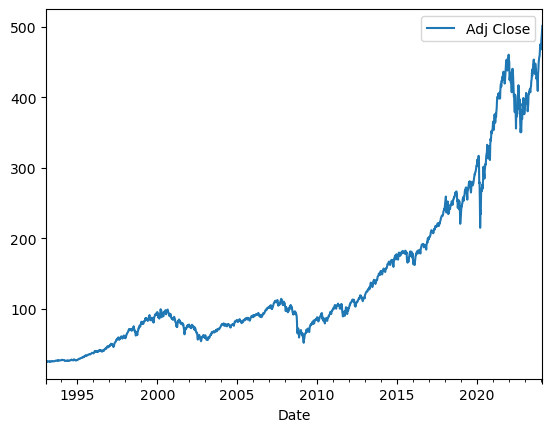

In [235]:
combined_df.plot.line(y='Adj Close', use_index=True)

In [236]:
combined_df.head()

,High,Low,Adj Close,Volume,VIX,SPY Tomorrow,Target
Date,,,,,,,
1993-01-25,43.96875,43.75000,24.840683,1003200,12.42,25.423706,1
1993-02-01,45.09375,43.96875,25.423706,2234800,12.90,25.211708,0
1993-02-08,45.12500,44.53125,25.211708,1159800,12.38,24.628672,0
1993-02-15,44.46875,42.81250,24.628672,998700,15.02,25.105690,1
1993-02-22,44.43750,43.46875,25.105690,1024300,13.16,25.300035,1


In [237]:
#reducing the size of the volume number to help the model run faster. 

combined_df["Volume"] = combined_df["Volume"].div(1000000)
combined_df["Volume"] = combined_df["Volume"].round(1)
combined_df

,High,Low,Adj Close,Volume,VIX,SPY Tomorrow,Target
Date,,,,,,,
1993-01-25,43.968750,43.750000,24.840683,1.0,12.42,25.423706,1
1993-02-01,45.093750,43.968750,25.423706,2.2,12.90,25.211708,0
1993-02-08,45.125000,44.531250,25.211708,1.2,12.38,24.628672,0
1993-02-15,44.468750,42.812500,24.628672,1.0,15.02,25.105690,1
1993-02-22,44.437500,43.468750,25.105690,1.0,13.16,25.300035,1
...,...,...,...,...,...,...,...
2024-01-08,478.600006,468.299988,476.679993,344.0,12.70,482.429993,1
2024-01-15,482.720001,469.869995,482.429993,356.4,13.30,487.410004,1
2024-01-22,489.119995,482.779999,487.410004,356.7,13.26,494.350006,1


In [238]:
# dropping last column because it contains an NA value. 
combined_df = combined_df[:-1]
combined_df

,High,Low,Adj Close,Volume,VIX,SPY Tomorrow,Target
Date,,,,,,,
1993-01-25,43.968750,43.750000,24.840683,1.0,12.42,25.423706,1
1993-02-01,45.093750,43.968750,25.423706,2.2,12.90,25.211708,0
1993-02-08,45.125000,44.531250,25.211708,1.2,12.38,24.628672,0
1993-02-15,44.468750,42.812500,24.628672,1.0,15.02,25.105690,1
1993-02-22,44.437500,43.468750,25.105690,1.0,13.16,25.300035,1
...,...,...,...,...,...,...,...
2024-01-01,473.670013,466.429993,467.920013,397.5,13.35,476.679993,1
2024-01-08,478.600006,468.299988,476.679993,344.0,12.70,482.429993,1
2024-01-15,482.720001,469.869995,482.429993,356.4,13.30,487.410004,1


In [239]:
from sklearn.ensemble import RandomForestClassifier

In [240]:
model = RandomForestClassifier(n_estimators=750, min_samples_split=200, random_state=1)

In [241]:
train = combined_df.iloc[:-750]
test = combined_df.iloc[-750:]

# Update predictors list with new features including VIX_Close
predictors = ["High", "Low", "Adj Close", "Volume", "VIX"]


model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, n_estimators=750, random_state=1)

In [242]:
# from sklearn.model_selection import GridSearchCV
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Example: Number of trees
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
# }

# # Initialize the grid search model
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(train[predictors], train["Target"])

# # Best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

In [243]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [244]:
preds = pd.Series(preds, index=test.index)

In [245]:
precision_score(test["Target"], preds)

0.5714285714285714

In [246]:
#Optmization

#Lag Features & SMA
lag_features = ['Adj Close']
lags = range(1, 4)  # for example, create lags for 1, 2, and 3 days
for lag in lags:
     combined_df[f'Adj Close Lag {lag}'] = combined_df['Adj Close'].shift(lag)
     combined_df[f'Volume Lag {lag}'] = combined_df['Volume'].shift(lag)
     #Add a simple moving average (SMA) for 'Adj Close
     window = 5  # 5-day SMA
     combined_df['SMA 5'] = combined_df['Adj Close'].rolling(window=window).mean()
     # Handle missing values introduced by lag and SMA features
     combined_df.dropna(inplace=True)

C:\Users\nemuk\AppData\Local\Temp\ipykernel_28092\549196780.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[f'Adj Close Lag {lag}'] = combined_df['Adj Close'].shift(lag)
C:\Users\nemuk\AppData\Local\Temp\ipykernel_28092\549196780.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[f'Volume Lag {lag}'] = combined_df['Volume'].shift(lag)
C:\Users\nemuk\AppData\Local\Temp\ipykernel_28092\549196780.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 